In [1]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import missingno as msno
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']


In [2]:
DATA_DIR = '../../data/data_clean.csv'
raw_df = pd.read_csv(DATA_DIR)
raw_df.columns
raw_df = raw_df.drop(['Source.Name','date','hour','tag'],axis=1)

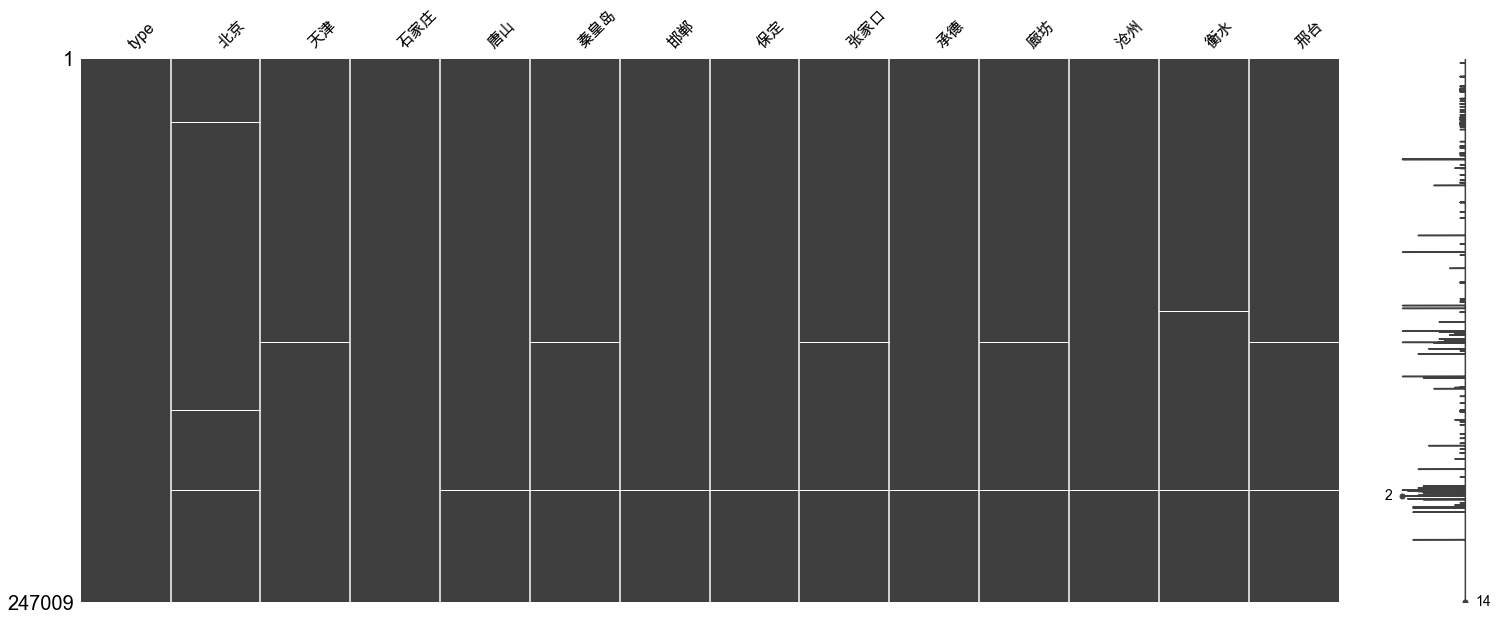

In [3]:
msno.matrix(raw_df);

### 使用O3 日度数据进行预测，将缺失数据剔除

In [4]:
O3 = raw_df[raw_df['type']=='O3_24h'].drop('type',axis=1)
O3['label'] = O3['北京'].shift(-15)
O3 = O3.dropna()

In [5]:
df = O3
df.shape

(60932, 14)

In [6]:
split_fraction = 0.725
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 200
future = 15
learning_rate = 0.0001
batch_size = 256
epochs = 20


In [7]:

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [8]:
features = df.drop(['label'],axis=1)
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [9]:
start = past + future
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = 200

In [10]:

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-08 23:24:28.856579: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-08 23:24:28.856713: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end,:].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 200, 13)
Target shape: (256, 1)


2022-05-08 23:24:28.955356: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [12]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(128)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)
drop_out = keras.layers.Dropout(0.1)(outputs)
model = keras.Model(inputs=inputs, outputs=drop_out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 13)]         0         
                                                                 
 lstm (LSTM)                 (None, 128)               72704     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 72,833
Trainable params: 72,833
Non-trainable params: 0
_________________________________________________________________


In [13]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, 
               modelckpt_callback]
            #    tensorboard_callback],
)

Epoch 1/20


2022-05-08 23:24:29.685762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 23:24:29.815780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 23:24:30.311986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - ETA: 0s - loss: 0.4887

2022-05-08 23:24:44.525562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 23:24:44.579133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.24666, saving model to model_checkpoint.h5
172/172 [==============================] - 18s 96ms/step - loss: 0.4887 - val_loss: 0.2467
Epoch 2/20
172/172 [==============================] - ETA: 0s - loss: 0.3915
Epoch 2: val_loss improved from 0.24666 to 0.24126, saving model to model_checkpoint.h5
172/172 [==============================] - 17s 101ms/step - loss: 0.3915 - val_loss: 0.2413
Epoch 3/20
172/172 [==============================] - ETA: 0s - loss: 0.3792
Epoch 3: val_loss improved from 0.24126 to 0.23480, saving model to model_checkpoint.h5
172/172 [==============================] - 16s 91ms/step - loss: 0.3792 - val_loss: 0.2348
Epoch 4/20
172/172 [==============================] - ETA: 0s - loss: 0.3667
Epoch 4: val_loss improved from 0.23480 to 0.22665, saving model to model_checkpoint.h5
172/172 [==============================] - 15s 88ms/step - loss: 0.3667 - val_loss: 0.2266
Epoch 5/20
172/172 [==============================] - E

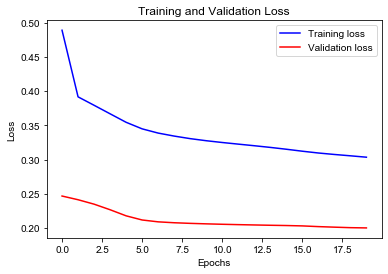

In [14]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [15]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



2022-05-08 23:29:26.795521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 23:29:26.833661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


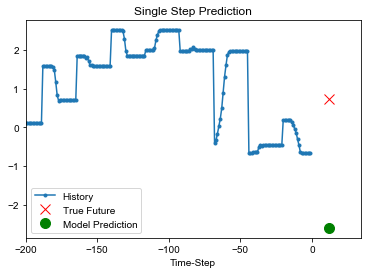

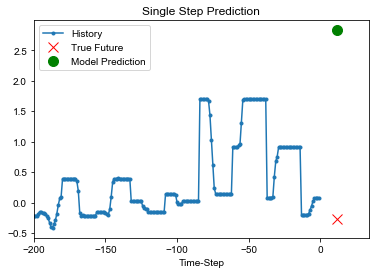

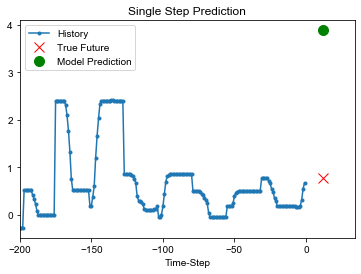

In [16]:

for x, y in dataset_val.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [17]:
pred = model.predict(dataset_val)

2022-05-08 23:29:28.098175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 23:29:28.149027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Text(0.5, 1.0, 'r2_score:0.4913')

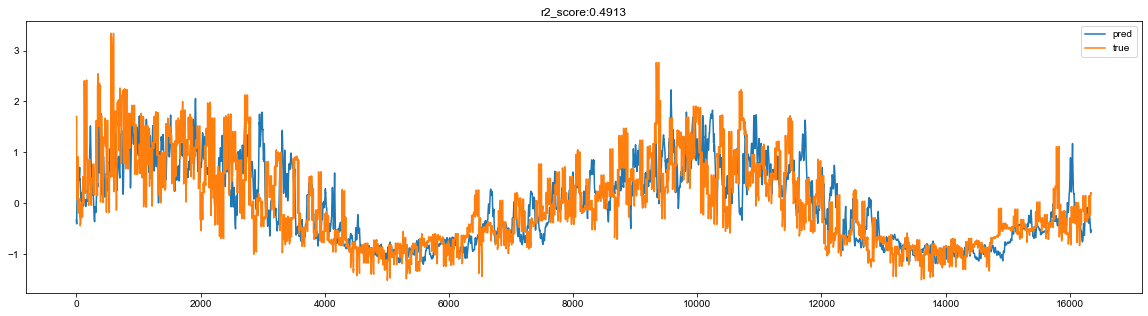

In [18]:
from sklearn.metrics import r2_score
y_pred = pred
y_true = y_val.values.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))
plt.plot(y_pred,label = 'pred')
plt.plot(y_true,label='true')
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))


In [19]:
model.save('./models/lstm_128_dense_1.h5')